In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.preprocessing import StandardScaler

数据导入

In [ ]:
house_train_df=pd.read_csv('ruc_Class25Q1_train.csv')
house_train_df.head(3)

,城市,区域,板块,环线,小区名称,价格,房屋户型,所在楼层,建筑面积,套内面积,...,产权所属,抵押信息,房屋优势,核心卖点,户型介绍,周边配套,交通出行,lon,lat,年份
0,0,79.0,111.0,二至三环,人定湖西里,6564200,2室1厅1厨1卫,中楼层 (共5层),52.3㎡,NaN,...,非共有,NaN,装修、房本满五年,此房是南北通透小板楼，户型方正，格局合理,房子是南北通透户型方正采光好，前后没有遮挡视野好，通风效果好,医院、公园、超市，生活便利，火箭军医院、积水潭医院，双秀公园，人定湖公园，物美超市、世纪华联等。,NaN,116.389326,39.963727,2018.0
1,0,43.0,231.0,五至六环,龙跃苑四区,4174000,3室1厅1厨1卫,顶层 (共6层),127.44㎡,123.7㎡,...,非共有,NaN,装修、房本满五年,南北通透商品房自住装修无个税,房子三居一卫，户型方正，南北通透，客厅朝南带阳台，主卧朝南，东向有窗户，次卧、厨房朝北，厨房...,医院：北京京都儿童医院、昌平中西结合医院，积水潭医院配套设施：美廉美，工商，农行，邮政等银行...,NaN,116.354287,40.079237,2017.0
2,0,97.0,54.0,五至六环,名都园,16310000,4室2厅1厨4卫,底层 (共3层),228.54㎡,NaN,...,非共有,NaN,房本满五年,有挑空客厅私家车库花园和*,地上三层地下一层四期密度低没有公寓一层车库可以做卧室花园有100平米左右,NaN,NaN,116.543168,40.078165,2018.0


In [ ]:
house_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84133 entries, 0 to 84132
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   城市      84133 non-null  int64  
 1   区域      84133 non-null  float64
 2   板块      84133 non-null  float64
 3   环线      42726 non-null  object 
 4   小区名称    84133 non-null  object 
 5   价格      84133 non-null  int64  
 6   房屋户型    83528 non-null  object 
 7   所在楼层    84133 non-null  object 
 8   建筑面积    84133 non-null  object 
 9   套内面积    25146 non-null  object 
 10  房屋朝向    84133 non-null  object 
 11  建筑结构    83528 non-null  object 
 12  装修情况    83528 non-null  object 
 13  梯户比例    82438 non-null  object 
 14  配备电梯    75818 non-null  object 
 15  别墅类型    749 non-null    object 
 16  交易时间    84133 non-null  object 
 17  交易权属    84133 non-null  object 
 18  上次交易    55180 non-null  object 
 19  房屋用途    84131 non-null  object 
 20  房屋年限    54351 non-null  object 
 21  产权所属    84133 non-null  object 
 22

特征工程

In [ ]:
df=house_train_df.drop(['区域','板块','小区名称','核心卖点','房屋优势','户型介绍','周边配套','交通出行','抵押信息','房屋朝向','套内面积','上次交易','交易时间','lat','lon','别墅类型'],axis=1)
#小区名称、核心卖点等字段实际意义有限
#抵押信息数据均为空值
#套内面积与建筑面积存在潜在多重共线性
#lon、lat和城市存在潜在多重共线性
df.head(3)

,城市,环线,价格,房屋户型,所在楼层,建筑面积,建筑结构,装修情况,梯户比例,配备电梯,交易权属,房屋用途,房屋年限,产权所属,年份
0,0,二至三环,6564200,2室1厅1厨1卫,中楼层 (共5层),52.3㎡,混合结构,精装,一梯三户,无,商品房,普通住宅,满五年,非共有,2018.0
1,0,五至六环,4174000,3室1厅1厨1卫,顶层 (共6层),127.44㎡,混合结构,精装,一梯两户,无,商品房,普通住宅,满五年,非共有,2017.0
2,0,五至六环,16310000,4室2厅1厨4卫,底层 (共3层),228.54㎡,混合结构,精装,一梯一户,无,商品房,普通住宅,满五年,非共有,2018.0


In [ ]:
#房屋用途
df = df.dropna(subset=['房屋用途'])
df['房屋用途'].value_counts()


房屋用途
普通住宅      79853
商业办公类      1178
别墅         1064
商住两用       1025
车库          605
公寓          160
写字楼          76
底商           49
商业           45
酒店式公寓        42
公寓/公寓        13
公寓/住宅         7
新式里弄          4
四合院           3
公寓（住宅）        2
老公寓           2
住宅式公寓         1
平房            1
花园洋房          1
Name: count, dtype: int64

In [ ]:
# 合并处理逻辑（先过滤后修改）
mask = df['房屋用途'].str.contains('公寓')
df.loc[mask, '房屋用途'] = '商住两用'

# 合并商业类数据（使用集合操作优化查询效率）
commercial_set = {'写字楼', '底商', '商业办公类'}
df.loc[df['房屋用途'].isin(commercial_set), '房屋用途'] = '商业'

# 过滤逻辑优化（使用位运算加速）
deprecated_set = {'四合院', '平房', '花园洋房', '新式里弄'}
df = df[~df['房屋用途'].isin(deprecated_set) & ~mask]  # 避免重复判断

In [ ]:
#面积
df['建筑面积'] = (
    df['建筑面积']
    .astype(str)  # 确保是字符串类型
    .str.replace(r'\s*㎡\s*', '', regex=True)  # 删除“㎡”及其前后空格
    .str.replace(r'[^0-9.]+', '', regex=True)  # 删除非数字字符（如“平方米”）
)
df['建筑面积'] = pd.to_numeric(df['建筑面积'], errors='coerce')

df.loc[df['建筑面积']>=1000]#查看异常值

,城市,环线,价格,房屋户型,所在楼层,建筑面积,建筑结构,装修情况,梯户比例,配备电梯,交易权属,房屋用途,房屋年限,产权所属,年份
21531,2,NaN,22976000,5室3厅2厨6卫,低楼层 (共3层),1000.00,钢混结构,精装,NaN,NaN,商品房,别墅,NaN,共有,2017.0
23549,2,NaN,20050000,5室2厅1厨3卫,低楼层 (共3层),1000.00,钢混结构,精装,NaN,NaN,商品房,别墅,满五年,非共有,2020.0
37426,2,NaN,22437000,9室3厅3厨8卫,低楼层 (共2层),1012.00,钢混结构,其他,NaN,NaN,商品房,别墅,NaN,非共有,2021.0
57713,5,NaN,332400,1室1厅1厨1卫,高楼层 (共12层),5108.00,钢混结构,简装,一梯三户,有,商品房,普通住宅,NaN,共有,2018.0
65221,5,NaN,7172400,5室3厅2厨2卫,低楼层 (共7层),1389.39,框架结构,其他,一梯三户,有,商品房,普通住宅,NaN,非共有,2021.0
77254,6,二至三环,13015900,1室0厅0厨0卫,低楼层 (共22层),1143.00,钢混结构,其他,一梯四户,NaN,商品房,商业,NaN,非共有,2021.0
77265,6,二至三环,3580000,1室0厅0厨0卫,高楼层 (共29层),1200.00,钢混结构,其他,五梯六户,有,商品房,商业,NaN,非共有,2021.0
78228,6,NaN,11390000,1室0厅0厨0卫,中楼层 (共30层),1250.00,钢混结构,其他,一梯一户,NaN,商品房,商业,NaN,非共有,2021.0
78229,6,NaN,11390000,1室0厅0厨0卫,中楼层 (共30层),1250.00,钢混结构,其他,一梯三户,NaN,商品房,商业,NaN,非共有,2021.0
82776,6,NaN,1095000,2室2厅1厨1卫,高楼层 (共24层),10337.00,钢混结构,其他,两梯六户,有,商品房,普通住宅,NaN,非共有,2022.0


In [ ]:
area_condition = df['建筑面积']>= 1000
usage_condition = df['房屋用途'] == '普通住宅'
df = df[~(area_condition & usage_condition)]#异常值处理


In [ ]:
df.loc[df['房屋户型'].isnull()]#查看异常值

,城市,环线,价格,房屋户型,所在楼层,建筑面积,建筑结构,装修情况,梯户比例,配备电梯,交易权属,房屋用途,房屋年限,产权所属,年份
22,0,四至五环,178000,NaN,地下室 (共0层),13.75,NaN,NaN,NaN,NaN,商品房,车库,满五年,非共有,2019.0
32,0,五至六环,178000,NaN,地下室 (共35层),38.92,NaN,NaN,NaN,NaN,商品房,车库,满两年,非共有,2018.0
86,0,三至四环,400000,NaN,地下室 (共29层),71.74,NaN,NaN,NaN,NaN,商品房,车库,满两年,非共有,2019.0
97,0,四至五环,192060,NaN,地下室 (共2层),88.69,NaN,NaN,NaN,NaN,商品房,车库,满五年,非共有,2019.0
104,0,四至五环,163200,NaN,地下室 (共2层),42.46,NaN,NaN,NaN,NaN,商品房,车库,满五年,非共有,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83622,6,NaN,86800,NaN,地下室 (共33层),15.00,NaN,NaN,NaN,NaN,使用权,车库,NaN,非共有,2022.0
83685,6,三环外,111650,NaN,地下室 (共0层),40.00,NaN,NaN,NaN,NaN,商品房,车库,NaN,非共有,2022.0
83686,6,三环外,90350,NaN,地下室 (共34层),25.00,NaN,NaN,NaN,NaN,商品房,车库,NaN,非共有,2022.0
83689,6,三环外,90350,NaN,地下室 (共34层),25.00,NaN,NaN,NaN,NaN,商品房,车库,NaN,非共有,2022.0


In [ ]:
#房屋户型
df = df.dropna(subset=['房屋户型'])#车库不具代表性，去除
layout_counts=df['房屋户型'].value_counts()
layout_counts_str=''

for i in range(0,layout_counts.size):
    layout_counts_str+=(layout_counts.index[i]+''+str(layout_counts.values[i])+'套;')
print(layout_counts_str)

2室1厅1厨1卫22664套;3室2厅1厨2卫11521套;2室2厅1厨1卫8911套;1室1厅1厨1卫8194套;3室2厅1厨1卫5905套;3室1厅1厨1卫5670套;4室2厅1厨2卫5021套;3室1厅1厨2卫3448套;1室0厅1厨1卫2473套;2室1厅1厨2卫1145套;4室1厅1厨2卫934套;4室2厅1厨3卫917套;2室2厅1厨2卫909套;5室2厅1厨3卫391套;5室2厅1厨2卫312套;3室2厅1厨3卫279套;2室0厅1厨1卫253套;1室0厅0厨1卫205套;1室2厅1厨1卫196套;2房间1卫187套;4室2厅1厨4卫175套;5室2厅1厨4卫150套;1房间1卫149套;1室0厅0厨0卫140套;4室2厅1厨1卫135套;1室1厅0厨1卫119套;5室3厅1厨3卫113套;4室1厅1厨3卫109套;3室2厅2厨2卫98套;3房间1卫93套;4室1厅1厨1卫89套;4室3厅1厨3卫72套;3室1厅1厨3卫70套;2房间2卫67套;5室3厅1厨4卫66套;4室2厅2厨2卫66套;2室1厅0厨1卫65套;3房间2卫64套;4室3厅1厨2卫60套;6室2厅1厨3卫53套;3室3厅1厨2卫50套;3室0厅1厨1卫49套;5室1厅1厨2卫49套;3室2厅0厨2卫47套;4房间2卫45套;6室2厅1厨4卫42套;3室3厅1厨3卫37套;5室1厅1厨3卫37套;4室2厅0厨2卫32套;3室2厅2厨1卫32套;5室2厅1厨5卫31套;4室3厅1厨4卫30套;6室3厅1厨3卫29套;2室1厅1厨0卫29套;1室1厅1厨2卫26套;6室2厅1厨2卫26套;2室2厅2厨2卫26套;5室3厅1厨5卫26套;3室1厅0厨1卫23套;4室2厅1厨5卫23套;5房间2卫22套;5室3厅1厨2卫21套;6室3厅1厨4卫21套;1室1厅0厨0卫21套;5室2厅2厨2卫19套;3室2厅1厨4卫19套;0室0厅0厨0卫18套;4室1厅1厨4卫18套;3室2厅0厨1卫17套;4房间1卫17套;5室3厅2厨4卫16套;1室1厅1厨0卫16套;5室2厅2厨3卫15套;5室1厅1厨4卫15套;1室2厅1厨2卫15套;4室2厅2厨3卫15套;1房间0卫15套;1室0厅1厨0卫14套;2室2厅0厨1卫14套;4室2厅2厨1卫14套;2室1厅2厨1卫14套;5室3厅2厨3卫14套;2室2

In [ ]:
df=df.loc[df['房屋户型'].str.extract('\d(.*?)\d.*?',expand=False)=='室']
#添加新特征
pd.set_option('mode.chained_assignment', None)#屏蔽警告
df['layout_room_num']=df['房屋户型'].str.extract('(^\d).*',expand=False).astype('int64')
df['layout_hall_num']=df['房屋户型'].str.extract('^\d.*?(\d).*',expand=False).astype('int64')
df['layout_cook_num'] = df['房屋户型'].str.extract('^\d.*?\d.*?(\d).*', expand=False).astype('int64')
df['layout_wc_num'] = df['房屋户型'].str.extract('^\d.*?\d.*?\d.*?(\d).*', expand=False).astype('int64')

df['房间数量']=df['layout_room_num']+df['layout_hall_num']+df['layout_cook_num']+df['layout_wc_num']
df['房间平均面积']=df['建筑面积']/df['房间数量']
#为消除潜在的多重共线性 消除冗余数据
df=df.drop(['layout_room_num','layout_hall_num','layout_cook_num','layout_wc_num','房间数量','建筑面积','房屋户型'],axis=1)
df

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
C:\Users\张雷臻\AppData\Local\Temp\ipykernel_16936\1771416103.py:1: SyntaxWarning: invalid escape sequence '\d'
  df=df.loc[df['房屋户型'].str.extract('\d(.*?)\d.*?',expand=False)=='室']
C:\Users\张雷臻\AppData\Local\Temp\ipykernel_16936\1771416103.py:4: SyntaxWarning: invalid escape sequence '\d'
  df['layout_room_num']=df['房屋户型'].str.extract('(^\d).*',expand=False).astype('int64')
C:\Users\张雷臻\AppData\Local\Temp\ipykernel_16936\1771416103.py:5: SyntaxWarning: invalid escape sequence '\d'
  df['layout_hal

,城市,环线,价格,所在楼层,建筑结构,装修情况,梯户比例,配备电梯,交易权属,房屋用途,房屋年限,产权所属,年份,房间平均面积
0,0,二至三环,6564200,中楼层 (共5层),混合结构,精装,一梯三户,无,商品房,普通住宅,满五年,非共有,2018.0,10.460000
1,0,五至六环,4174000,顶层 (共6层),混合结构,精装,一梯两户,无,商品房,普通住宅,满五年,非共有,2017.0,21.240000
2,0,五至六环,16310000,底层 (共3层),混合结构,精装,一梯一户,无,商品房,普通住宅,满五年,非共有,2018.0,20.776364
6,0,五至六环,6875000,顶层 (共8层),钢混结构,简装,一梯两户,有,商品房,普通住宅,满五年,非共有,2019.0,20.457143
8,0,四至五环,3138000,顶层 (共6层),混合结构,精装,一梯两户,无,商品房,普通住宅,满五年,共有,2017.0,18.120000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84128,6,NaN,1059500,高楼层 (共33层),框架结构,精装,三梯六户,有,商品房,普通住宅,满五年,共有,2022.0,15.686667
84129,6,二至三环,1087900,中楼层 (共30层),钢混结构,精装,两梯六户,有,商品房,普通住宅,满五年,非共有,2022.0,17.575000
84130,6,NaN,967200,高楼层 (共32层),钢混结构,精装,两梯六户,有,商品房,普通住宅,满五年,非共有,2022.0,13.450000
84131,6,二至三环,1095000,中楼层 (共7层),混合结构,精装,一梯两户,无,商品房,普通住宅,满五年,非共有,2022.0,15.193333


In [ ]:
#楼层
floor_info = df['所在楼层'].astype(str)
df['总楼层'] = pd.to_numeric(
    floor_info.str.extract(r'共(\d+)层', expand=False),
    errors='coerce'
).fillna(0).astype('int64')
df['所在楼层'] = floor_info.str.replace(
        r'\s*共\d+层\s*|[()（）]',  # 合并匹配模式：同时处理楼层信息和括号
        '', 
        regex=True
    ).str.strip()
#删去少数异常值
df[df['总楼层'] != 0]

,城市,环线,价格,所在楼层,建筑结构,装修情况,梯户比例,配备电梯,交易权属,房屋用途,房屋年限,产权所属,年份,房间平均面积,总楼层
0,0,二至三环,6564200,中楼层,混合结构,精装,一梯三户,无,商品房,普通住宅,满五年,非共有,2018.0,10.460000,5
1,0,五至六环,4174000,顶层,混合结构,精装,一梯两户,无,商品房,普通住宅,满五年,非共有,2017.0,21.240000,6
2,0,五至六环,16310000,底层,混合结构,精装,一梯一户,无,商品房,普通住宅,满五年,非共有,2018.0,20.776364,3
6,0,五至六环,6875000,顶层,钢混结构,简装,一梯两户,有,商品房,普通住宅,满五年,非共有,2019.0,20.457143,8
8,0,四至五环,3138000,顶层,混合结构,精装,一梯两户,无,商品房,普通住宅,满五年,共有,2017.0,18.120000,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84128,6,NaN,1059500,高楼层,框架结构,精装,三梯六户,有,商品房,普通住宅,满五年,共有,2022.0,15.686667,33
84129,6,二至三环,1087900,中楼层,钢混结构,精装,两梯六户,有,商品房,普通住宅,满五年,非共有,2022.0,17.575000,30
84130,6,NaN,967200,高楼层,钢混结构,精装,两梯六户,有,商品房,普通住宅,满五年,非共有,2022.0,13.450000,32
84131,6,二至三环,1095000,中楼层,混合结构,精装,一梯两户,无,商品房,普通住宅,满五年,非共有,2022.0,15.193333,7


In [ ]:
#电梯
#有较多缺失值，不便于删除，考虑利用楼层信息进行补充
pd.set_option('mode.chained_assignment', None)#屏蔽警告
df.loc[(df['总楼层']>7) & (df['配备电梯'].isnull()), '配备电梯'] = '有'
df.loc[(df['总楼层']<=7) & (df['配备电梯'].isnull()), '配备电梯'] = '无'

In [ ]:
#房屋年限
#缺失值处理
pd.set_option('mode.chained_assignment', None)#屏蔽警告
df.loc[df['房屋年限'].isnull(), '房屋年限'] = '未知'


In [ ]:
#梯户比例
def convert_chinese(s):
    """
    将中文数字字符串转换为对应的整数数值。
    支持组合数字如“十一”、“二十”等。
    """
    num_map = {
        '一': 1, '二': 2, '两': 2, '三': 3, '四': 4,
        '五': 5, '六': 6, '七': 7, '八': 8, '九': 9, '十': 10
    }
    total = 0
    current = 0
    for c in s:
        val = num_map.get(c, 0)
        if val == 10:  # 处理“十”的情况
            if current == 0:
                total += 10
            else:
                total += current * 10
                current = 0
        else:
            current += val
    total += current
    return total

def process_elevator_ratio(df):
    """
    处理'梯户比例'列，提取梯数和户数，支持阿拉伯数字和中文数字格式。
    """
    # 删除缺失值
    df = df.dropna(subset=['梯户比例'])
    
    # 处理阿拉伯数字格式（如"2梯3户"或"2T3户"）
    arabic_pattern = r'(\d+)(?:梯|T)(\d+)户'
    arabic_df = df['梯户比例'].str.extract(arabic_pattern)
    arabic_df.columns = ['梯数', '户数']
    arabic_df = arabic_df.astype(float)
    
    # 处理中文数字格式（如"一梯两户"）
    chinese_pattern = r'([一二两三四五六七八九十]+)梯([一二两三四五六七八九十]+)户'
    chinese_df = df['梯户比例'].str.extract(chinese_pattern)
    
    # 转换中文数字列
    def convert_series(s):
        return s.apply(lambda x: convert_chinese(x) if pd.notna(x) else np.nan)
    
    chinese_converted = pd.DataFrame({
        '梯数': convert_series(chinese_df[0]),
        '户数': convert_series(chinese_df[1])
    })
    
    # 合并阿拉伯数字和中文数字的处理结果
    df[['梯数', '户数']] = arabic_df.fillna(chinese_converted)
    
    return df
df = process_elevator_ratio(df)
df['梯户比例']=(df['梯数']/df['户数']).round(3)


In [ ]:
#交易权属
df['交易权属'].value_counts()

交易权属
商品房        75290
已购公房        2511
拆迁还建房        798
二类经济适用房      579
经济适用房        462
一类经济适用房      397
动迁安置房        341
限价商品房        263
集资房          227
私产           213
央产房          155
房改房          127
定向安置房         55
售后公房          36
自住型商品房        25
使用权            1
Name: count, dtype: int64

In [ ]:
df.loc[df['交易权属'].str.contains('商品房', na=False), '交易权属'] = '商品房'
# 合并数据（使用集合操作优化查询效率）
eco_set = {'一类经济适用房', '二类经济适用房', '定向经济适用房', '集资房'}
com_set = {'拆迁还建房', '动迁安置房', '定向安置房'}
pub_set = {'已购公房', '售后公房', '央产房','房改房'}

df.loc[df['交易权属'].isin(eco_set), '交易权属'] = '经济适用房'
df.loc[df['交易权属'].isin(com_set), '交易权属'] = '安置房'
df.loc[df['交易权属'].isin(pub_set), '交易权属'] = '公房'


df['交易权属'].value_counts()


交易权属
商品房      75578
公房        2829
经济适用房     1665
安置房       1194
私产         213
使用权          1
Name: count, dtype: int64

In [ ]:
#环线
df = df.dropna(subset=['环线'])
df['环线'].value_counts()

环线
内环内      8718
二至三环     8613
五至六环     5211
三至四环     4181
四至五环     2642
三环外      2110
外环外      1948
一至二环     1853
六环外      1798
内环至外环    1028
中环至外环     918
内环至中环     885
二环内       600
一环内       347
四环外       110
Name: count, dtype: int64

In [ ]:
# 合并数据（使用集合操作优化查询效率）
near_set = {'内环内', '一至二环', '一环内', '二环内'}
mid_set = {'内环至中环', '中环至外环','内环至外环', '二至三环','三至四环','四至五环'}
sur_set = {'外环外','三环外', '四环外','五至六环','六环外'}

df.loc[df['环线'].isin(near_set), '环线'] = '内环'
df.loc[df['环线'].isin(mid_set), '环线'] = '中环'
df.loc[df['环线'].isin(sur_set), '环线'] = '外环'
df['环线'].value_counts()

环线
中环    18267
内环    11518
外环    11177
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40962 entries, 0 to 84131
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   城市      40962 non-null  int64  
 1   环线      40962 non-null  object 
 2   价格      40962 non-null  int64  
 3   所在楼层    40962 non-null  object 
 4   建筑结构    40962 non-null  object 
 5   装修情况    40962 non-null  object 
 6   梯户比例    40962 non-null  float64
 7   配备电梯    40962 non-null  object 
 8   交易权属    40962 non-null  object 
 9   房屋用途    40962 non-null  object 
 10  房屋年限    40962 non-null  object 
 11  产权所属    40962 non-null  object 
 12  年份      40962 non-null  float64
 13  房间平均面积  40962 non-null  float64
 14  总楼层     40962 non-null  int64  
 15  梯数      40962 non-null  float64
 16  户数      40962 non-null  float64
dtypes: float64(5), int64(3), object(9)
memory usage: 5.6+ MB


In [ ]:
#离散型特征编码
# 离散型特征编码（包含城市列特殊处理）
try:
    # 强制指定需要编码的列（包含自动检测+显式添加）
    categorical_columns = df.columns[df.dtypes == 'object'].tolist()
    
    # 显式添加城市列（即使不是object类型）
    if '城市' in df.columns:
        if '城市' not in categorical_columns:
            categorical_columns.append('城市')
        # 确保转换为字符串类型（防止数值型城市编码被误判）
        df['城市'] = df['城市'].astype(str)
    
    if categorical_columns:
        # 内存监控
        mem_before = df.memory_usage().sum() / 1024**2
        
        # 执行独热编码（保持原始列名）
        df = pd.get_dummies(df, columns=categorical_columns,
                          prefix_sep=':', dummy_na=False)
        
        # 内存报告
        mem_after = df.memory_usage().sum() / 1024**2
        print(f"编码后内存变化：{mem_after - mem_before:+.2f} MB")
        
        # 列名清洗（可选）
        df.columns = df.columns.str.replace(':', '_')
    else:
        print("警告：未找到需要编码的分类列")
        
except KeyError as e:
    print(f"关键列缺失：需要的城市列 {e} 不存在")
except Exception as e:
    print(f"编码失败：{type(e).__name__} - {str(e)}")

df

编码后内存变化：-1.52 MB


,价格,梯户比例,年份,房间平均面积,总楼层,梯数,户数,环线_中环,环线_内环,环线_外环,...,房屋年限_未知,房屋年限_满两年,房屋年限_满五年,产权所属_共有,产权所属_非共有,城市_0,城市_2,城市_3,城市_4,城市_6
0,6564200,0.333,2018.0,10.460000,5,1.0,3.0,True,False,False,...,False,False,True,False,True,True,False,False,False,False
1,4174000,0.500,2017.0,21.240000,6,1.0,2.0,False,False,True,...,False,False,True,False,True,True,False,False,False,False
2,16310000,1.000,2018.0,20.776364,3,1.0,1.0,False,False,True,...,False,False,True,False,True,True,False,False,False,False
6,6875000,0.500,2019.0,20.457143,8,1.0,2.0,False,False,True,...,False,False,True,False,True,True,False,False,False,False
8,3138000,0.500,2017.0,18.120000,6,1.0,2.0,True,False,False,...,False,False,True,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84118,1024000,0.400,2022.0,12.755000,33,2.0,5.0,False,False,True,...,False,False,True,False,True,False,False,False,False,True
84120,1143280,0.500,2022.0,13.647500,28,2.0,4.0,False,False,True,...,False,True,False,False,True,False,False,False,False,True
84123,1485500,0.500,2022.0,12.891429,34,2.0,4.0,True,False,False,...,False,False,False,False,True,False,False,False,False,True
84129,1087900,0.333,2022.0,17.575000,30,2.0,6.0,True,False,False,...,False,False,True,False,True,False,False,False,False,True


In [ ]:
new_column = [c for c in df.columns if c not in categorical_columns]
print(new_column)

['价格', '梯户比例', '年份', '房间平均面积', '总楼层', '梯数', '户数', '环线_中环', '环线_内环', '环线_外环', '所在楼层_中楼层', '所在楼层_低楼层', '所在楼层_地下室', '所在楼层_底层', '所在楼层_顶层', '所在楼层_高楼层', '建筑结构_未知结构', '建筑结构_框架结构', '建筑结构_混合结构', '建筑结构_砖木结构', '建筑结构_砖混结构', '建筑结构_钢混结构', '建筑结构_钢结构', '装修情况_其他', '装修情况_毛坯', '装修情况_简装', '装修情况_精装', '配备电梯_无', '配备电梯_有', '交易权属_公房', '交易权属_商品房', '交易权属_安置房', '交易权属_私产', '交易权属_经济适用房', '房屋用途_商业', '房屋用途_商住两用', '房屋用途_普通住宅', '房屋年限_未满两年', '房屋年限_未知', '房屋年限_满两年', '房屋年限_满五年', '产权所属_共有', '产权所属_非共有', '城市_0', '城市_2', '城市_3', '城市_4', '城市_6']


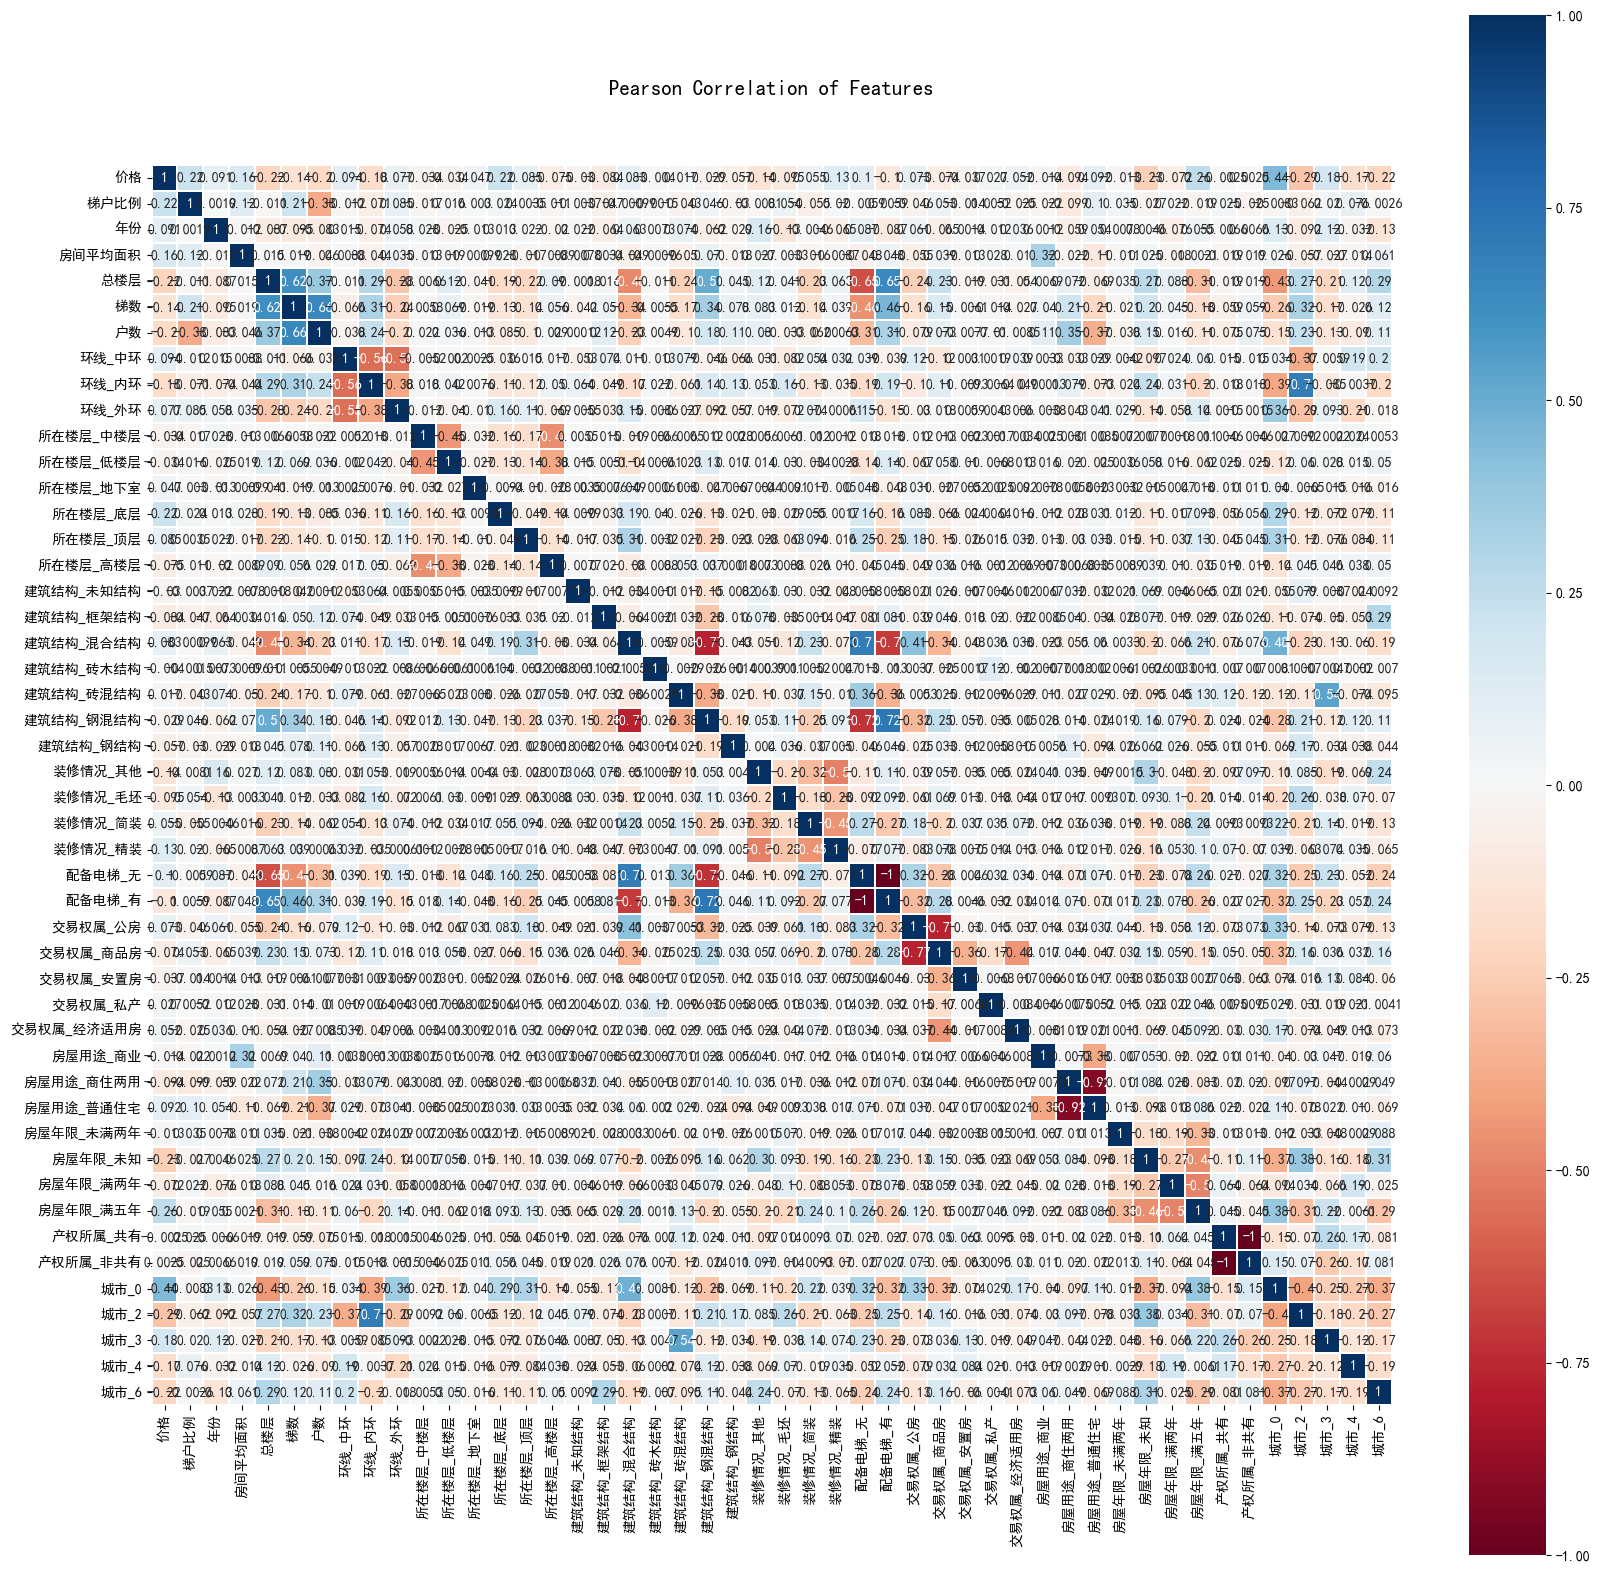

In [ ]:
# ====== 可视化验证 ======
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
#特征相关性
colormap = plt.cm.RdBu
plt.figure(figsize=(20, 20))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True) 
plt.show()
    

模型训练

In [ ]:
# 加载数据集
data1 = df
# 检查是否存在 NaN 值
nan_check = data1.isnull().sum().sum()
# 检查是否存在无穷大值
inf_check = data1.isin([np.inf, -np.inf]).sum().sum()
if nan_check > 0 or inf_check > 0:
    # 处理 NaN 值或者无穷大值
    # 填充缺失值为均值
    data1 = data1.fillna(data1.mean())
    # 删除包含 NaN 值或者无穷大值的行
    data1 = data1.dropna()
# 检查数据类型和数据范围
# 将价格列转换为浮点型
data1['价格'] = data1['价格'].astype('float64')
# 检查数据是否超出范围
data_check = np.isfinite(data1).all().all()

#将数据集分为训练集和测试集
X = df.drop('价格', axis=1)
y = df['价格']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

In [ ]:
# 处理 NaN 和无穷值
X_train = np.nan_to_num(X_train, posinf=1e10, neginf=-1e10)
X_train = np.clip(X_train, -1e10, 1e10)
X_test = np.nan_to_num(X_test, posinf=1e10, neginf=-1e10)
X_test = np.clip(X_test, -1e10, 1e10)
#数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 初始化模型
models = {
    'OLS': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet()
}

# 超参数
params = {
    'Lasso': {'alpha': [0.01, 0.1, 1, 10]},
    'Ridge': {'alpha': [0.01, 0.1, 1, 10]},
    'ElasticNet': {'alpha': [0.01, 0.1, 1], 'l1_ratio': [0.5, 0.7, 0.9]}
}

# 训练和评估模型
results = {}
for name in models:
    if name in params:
        grid = GridSearchCV(models[name], params[name], cv=6, scoring='neg_mean_absolute_error')
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
    else:
        best_model = models[name].fit(X_train, y_train)
    
    # 预测
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    # 计算指标
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    medae_test = median_absolute_error(y_test, y_pred_test)
    
    # 交叉验证
    cv_mae = -cross_val_score(best_model, X_train, y_train, cv=6, scoring='neg_mean_absolute_error').mean()
    cv_rmse = np.sqrt(-cross_val_score(best_model, X_train, y_train, cv=6, scoring='neg_mean_squared_error').mean())
    
    results[name] = {
        'In-Sample MAE': mae_train,
        'In-Sample RMSE': rmse_train,
        'Out-of-Sample MAE': mae_test,
        'Out-of-Sample RMSE': rmse_test,
        'Out-of-Sample MedAE': medae_test,
        '6-Fold CV MAE': cv_mae,
        '6-Fold CV RMSE': cv_rmse
    }

# 输出结果
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.2f}")
    print()

# 使用最佳模型预测房价
best_model = Ridge(alpha=1)  # 假设 Ridge 是最佳模型
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# 创建预测结果 DataFrame
results_df = pd.DataFrame({
    '真实房价': y_test.reset_index(drop=True),
    '预测房价': y_pred.round(2)
})

# 保存预测结果到 CSV
results_df.to_csv('房价预测结果.csv', index=False, encoding='utf-8-sig')
print("预测结果已保存至 房价预测结果.csv")

C:\Users\张雷臻\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.099e+16, tolerance: 2.570e+13
  model = cd_fast.enet_coordinate_descent(
C:\Users\张雷臻\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.489e+16, tolerance: 2.579e+13
  model = cd_fast.enet_coordinate_descent(
C:\Users\张雷臻\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi